<a href="https://colab.research.google.com/github/SNMS95/ADTO/blob/main/TO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === User-defined Settings for Topology Optimization ===

ML_framework_to_use = "torch"  # Choose ML backend: "torch" or "jax"

# Grid resolution (number of finite elements in x and y directions)
Nx = 96                       # Number of elements along x-axis
Ny = 64                       # Number of elements along y-axis

# Material properties
E0 = 1.0                     # Young's modulus of solid material
Emin = 1e-9                  # Young's modulus of void
nu = 0.3                     # Poisson's ratio

# Filter and penalization
rmin = 2.0                   # Radius for density filter
penal = 3.0                  # SIMP penalization factor

# Optimization control
max_iterations = 30         # Number of optimization steps
volfrac = 0.4

# # Sanity checks
# assert ML_framework_to_use in ["jax", "torch"]
assert penal >= 1
assert rmin >= 1

In [2]:
# Check if in Colab and setup accordingly
try:
    import google.colab
    # We're in Colab - clone and setup
    import os
    if not os.path.exists('ADTO'):
        !git clone https://github.com/SNMS95/ADTO.git
    %cd ADTO
    print("🔧 Colab setup complete")
except:
    # We're running locally - no setup needed
    # just ensure we're in the right directory
    %cd ..
    print("🔧 Running locally")

# Set backend before importing anything else
import os
os.environ["ML_BACKEND"] = ML_framework_to_use
from non_ad_ops import setup_fea_problem, optimality_criteria
from ad_backend import (compute_compliance_differentiable,
                        apply_density_filter,
                        solve,
                        assemble_stiffness_matrix_parts,
                        reduce_K)

/Users/suryanarayanan/Desktop/Phd/papers/educational/ADTO
🔧 Running locally
Using backend: torch


In [15]:
def simp_and_reduced_solve(physical_densities, problem_data):
    # Compute compliance
    E = problem_data['E_min'] + physical_densities**penal * \
        (problem_data['E0'] - problem_data['E_min'])
    iK, jK, sK = assemble_stiffness_matrix_parts(E, problem_data)
    free_dofs = problem_data['free']
    f = problem_data['F']
    f_f = f[free_dofs]
    # reduce K to K_f
    iK_f, jK_f, sK_f = reduce_K(iK, jK, sK, free_dofs, len(f))
    # Solve system
    if ML_framework_to_use == "torch":
        # Torch needs tensor inputs to be passed since we provide gradients w.r.t the force vector as well in teh custom VJP rule
        u_f = solve(sK_f, iK_f, jK_f, torch.Tensor(f_f))
    return u_f


def run_with_jax_backend(problem_data, rho_init=None, max_iterations=100):
    """Training example with JAX backend"""
    import jax
    import jax.numpy as jnp
    print("Training with JAX backend...")

    # Initialize design variables
    if rho_init is None:
        rho_init = jnp.ones((problem_data['Ny'], problem_data['Nx'])) * volfrac  # Initial guess
    else:
        assert rho_init.shape == (problem_data['Ny'], problem_data['Nx'])
    # Create loss function and optimizer

    def volume_constraint_fn(rho):
        """Needed only for OC update"""
        rho = rho.ravel(order='F')
        physical_densities = apply_density_filter(rho, problem_data)
        constraint = jnp.mean(physical_densities) - volfrac
        return constraint

    def obj_and_constraint_fn(rho):
        rho = rho.ravel(order='F')
        physical_densities = apply_density_filter(rho, problem_data)
        # Compute compliance - SIMP, assemble K, Remove free DOFs, solve system
        u_f = simp_and_reduced_solve(physical_densities, problem_data)
        f_f = problem_data['F'][problem_data['free']]
        compliance = u_f.T @ f_f
        constraint = jnp.mean(physical_densities) - volfrac
        aux_info= (compliance, constraint, physical_densities)
        return (compliance, constraint), aux_info

    # Training loop
    objs = []
    constraints = []
    designs = []

    rho = rho_init

    for itr in range(max_iterations):
        jacobian, aux = jax.jacrev(obj_and_constraint_fn, has_aux=True)(rho)
        obj_grads = jacobian[0]
        constraint_grads = jacobian[1]
        rho = optimality_criteria(
            rho.ravel(), obj_grads.ravel(), constraint_grads.ravel(),
            vol_constr_fn=volume_constraint_fn)
        obj, constr, design = aux
        objs.append(obj)
        constraints.append(constr)
        designs.append(design)
        if itr % 1 == 0:
            print(f"JAX - Iteration {itr}, Obj: {obj:.6f}, constr: {constr:.6f}")

    return objs, constraints, designs


def run_with_torch_backend(problem_data, rho_init=None, max_iterations=100):
    """Training example with PyTorch backend"""
    import torch
    print("Training with PyTorch backend...")

    # Initialize design variables
    if rho_init is None:
        rho_init = torch.ones((problem_data['Ny'], problem_data['Nx'])) * volfrac  # Initial guess
    else:
        assert rho_init.shape == (problem_data['Ny'], problem_data['Nx'])
    rho = rho_init.clone().requires_grad_(True)

    def volume_constraint_fn(rho_np):
        rho_torch = torch.from_numpy(rho_np)
        rho = rho_torch.t().reshape(-1)  # equivalent to Fortran order flatten
        # Apply filter
        physical_densities = apply_density_filter(rho, problem_data)
        constraint = torch.mean(physical_densities) - volfrac
        return constraint.detach().cpu().numpy().item()

    def obj_and_constraint_fn(rho):
        rho = rho.t().reshape(-1)  # equivalent to Fortran order flatten
        # Apply filter
        physical_densities = apply_density_filter(rho, problem_data)
        u_f = simp_and_reduced_solve(physical_densities, problem_data)
        compliance = u_f @ torch.Tensor(problem_data['F'][problem_data['free']])
        constraint = torch.mean(physical_densities) - volfrac
        aux_info= (compliance.item(), constraint.item(), physical_densities.detach().cpu().numpy())
        return compliance, constraint, aux_info

    # Training loop
    objs = []
    constraints = []
    designs = []

    for itr in range(max_iterations):
        obj, constr, aux = obj_and_constraint_fn(rho)

        # Compute gradients
        obj_grads = torch.autograd.grad(obj, rho, retain_graph=True)[0]
        constraint_grads = torch.autograd.grad(constr, rho)[0]

        # Convert to numpy (Fortran ordering)
        rho_np = optimality_criteria(
                rho.detach().cpu().numpy().ravel(order='F'),
                obj_grads.detach().cpu().numpy().ravel(order='F'),
                constraint_grads.detach().cpu().numpy().ravel(order='F'),
                vol_constr_fn=volume_constraint_fn,
                )

        # Update rho (new leaf tensor)
        rho = torch.from_numpy(rho_np.reshape(problem_data['Ny'], problem_data['Nx'],
                                               order='F')).requires_grad_(True)

        obj_np, constr_np, design = aux
        objs.append(obj_np)
        constraints.append(constr_np)
        designs.append(design)

        if itr % 1 == 0:
            print(f"PyTorch - Iteration {itr}, Obj: {obj_np:.6f}, constr: {constr_np:.6f}")

    return objs, constraints, designs


    
def run_optimization(problem_data, rho_init=None, max_iterations=100):
    """Train the neural network model."""
    backend = ML_framework_to_use
    if backend == "jax":
        return run_with_jax_backend(problem_data, rho_init=rho_init, max_iterations=max_iterations)
    elif backend == "torch":
        return run_with_torch_backend(problem_data, rho_init=rho_init, max_iterations=max_iterations)
    else:
        raise ValueError(f"Unknown backend: {backend}")

In [16]:
problem_data = setup_fea_problem(Nx=Nx, Ny=Ny, rmin=rmin, E0=E0, Emin=Emin, penal=penal,
                        nu=nu)
objs, const, designs = run_optimization(problem_data, max_iterations=max_iterations)

Training with PyTorch backend...
PyTorch - Iteration 0, Obj: 498.232813, constr: 0.000000
PyTorch - Iteration 1, Obj: 265.604539, constr: 0.000996
PyTorch - Iteration 2, Obj: 184.431438, constr: -0.000331
PyTorch - Iteration 3, Obj: 137.536895, constr: -0.000548
PyTorch - Iteration 4, Obj: 117.858438, constr: -0.000145
PyTorch - Iteration 5, Obj: 103.780279, constr: -0.000791
PyTorch - Iteration 6, Obj: 93.300689, constr: -0.000244
PyTorch - Iteration 7, Obj: 86.732660, constr: -0.000819
PyTorch - Iteration 8, Obj: 81.777456, constr: 0.000654
PyTorch - Iteration 9, Obj: 78.179222, constr: 0.000303
PyTorch - Iteration 10, Obj: 74.549939, constr: 0.000301
PyTorch - Iteration 11, Obj: 71.000164, constr: -0.000281
PyTorch - Iteration 12, Obj: 68.085115, constr: 0.000026
PyTorch - Iteration 13, Obj: 66.034919, constr: 0.000202
PyTorch - Iteration 14, Obj: 65.017833, constr: -0.000794
PyTorch - Iteration 15, Obj: 64.175706, constr: 0.000359
PyTorch - Iteration 16, Obj: 63.647786, constr: 0.0

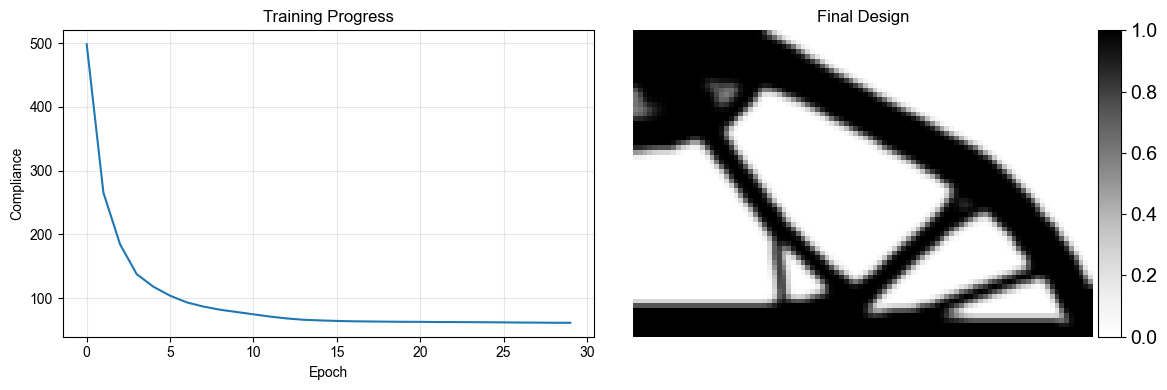

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss curve
ax1.plot(objs,)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Compliance')
ax1.set_title('Training Progress')
ax1.grid(True, alpha=0.3)

# Final design
im = ax2.imshow(designs[-1].reshape(Ny, Nx, order='F'), cmap="Greys")
ax2.set_title('Final Design')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.axis("off")
# Attach colorbar axis with same height
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)  # narrow, right-side
cbar = fig.colorbar(im, cax=cax)

# Formatting
cbar.ax.tick_params(labelsize=14)
plt.rcParams.update({"font.sans-serif": "Arial", "font.family": "sans-serif"})

# Save as PDF
fig.savefig("design.pdf", bbox_inches="tight", dpi=300)
plt.tight_layout()
plt.show()